In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from codecarbon import EmissionsTracker
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"CUDA is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"Current GPU: {torch.cuda.current_device()}")

    torch.cuda.empty_cache()

    torch.cuda.set_per_process_memory_fraction(0.5) 
else:
    print("CUDA is not available. Using CPU.")

device

Using device: cuda
CUDA is available!
GPU Name: NVIDIA GeForce RTX 2050
GPU Memory: 4.3 GB
Number of GPUs: 1
Current GPU: 0


device(type='cuda')

In [3]:
df = pd.read_csv('data/all_data.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414829 entries, 0 to 414828
Data columns (total 18 columns):
 #   Column                                                 Non-Null Count   Dtype  
---  ------                                                 --------------   -----  
 0   PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                       414829 non-null  float64
 1   PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  414829 non-null  float64
 2   PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)        414829 non-null  float64
 3   PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)       414829 non-null  float64
 4   RADIACAO GLOBAL (Kj/m²)                                414829 non-null  float64
 5   TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)           414829 non-null  float64
 6   TEMPERATURA DO PONTO DE ORVALHO (°C)                   414829 non-null  float64
 7   TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)             414829 non-null  float64
 8   TEMPERATURA MÍNIMA NA HORA ANT. (A

In [4]:
df['datetime'] = pd.to_datetime(df['datetime'])

df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

input_data = df.drop([
    'datetime',
    'TEMPERATURA DO PONTO DE ORVALHO (°C)',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], axis=1)
targets = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].values
T = 20                   
D = input_data.shape[1] 
N = len(input_data) - T

In [9]:
#Train size: 80% of the total data size
train_size = int(len(input_data) * 0.80)

# Normalization of the inputs
scaler = StandardScaler()
scaler.fit(input_data[:train_size + T - 1])
input_data = scaler.transform(input_data)

# Preparing X_train and y_train
X_train = np.zeros((train_size, T, D))
y_train = np.zeros((train_size, 1))

for t in range(train_size):
  X_train[t, :, :] = input_data[t:t+T]
  y_train[t] = (targets[t+T])

# Preparing X_test and y_test
X_test = np.zeros((N - train_size, T, D))
y_test = np.zeros((N - train_size, 1))

for i in range(N - train_size):
  t = i + train_size
  X_test[i, :, :] = input_data[t:t+T]
  y_test[i] = (targets[t+T])

# Make inputs and targets
X_train = torch.from_numpy(X_train.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
    super(LSTM, self).__init__()
    self.M = hidden_dim
    self.L = layer_dim

    self.rnn = nn.LSTM(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=layer_dim,
        batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)

  def forward(self, X):
    device = X.device  # Use the same device as input
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    out, (hn, cn) = self.rnn(X, (h0.detach(), c0.detach()))

    out = self.fc(out[:, -1, :])
    return out

In [8]:
model = LSTM(input_dim=D, hidden_dim=256, layer_dim=2, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [9]:
def train(model, learning_rate, X_train, y_train, X_test, y_test, epochs=100, batch_size=32):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{epochs}] — Train Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")

    return train_losses, test_losses

In [ ]:
def return_rmse(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu() 
            predictions.append(batch_pred)

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    return rmse

In [50]:
tracker = EmissionsTracker(
    project_name="TEMP lstm",
    output_file='codecarbon-lstm/codecarbon_emissions_temp.csv',
    log_level = "critical"
)

tracker.start()

train_losses, test_losses = train(
    model,
    learning_rate=0.01,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    epochs=25,
    batch_size=64
)

emissions: float = tracker.stop()
print(f"emissions={emissions}")

Epoch [1/25] — Train Loss: 6.3469, Test Loss: 7.8998


Epoch [2/25] — Train Loss: 6.2944, Test Loss: 7.5967


Epoch [3/25] — Train Loss: 6.2239, Test Loss: 6.9419


Epoch [4/25] — Train Loss: 6.2140, Test Loss: 7.1153


Epoch [5/25] — Train Loss: 6.1976, Test Loss: 7.0792


Epoch [6/25] — Train Loss: 6.2352, Test Loss: 7.2412


Epoch [7/25] — Train Loss: 6.1582, Test Loss: 7.0941


Epoch [8/25] — Train Loss: 6.1789, Test Loss: 7.1383


Epoch [9/25] — Train Loss: 6.1908, Test Loss: 6.8194


Epoch [10/25] — Train Loss: 6.1085, Test Loss: 7.0639


Epoch [11/25] — Train Loss: 6.0901, Test Loss: 7.2036


Epoch [12/25] — Train Loss: 6.1129, Test Loss: 7.5600


Epoch [13/25] — Train Loss: 6.0643, Test Loss: 6.8329


Epoch [14/25] — Train Loss: 6.0049, Test Loss: 6.8445


Epoch [15/25] — Train Loss: 6.0537, Test Loss: 6.7406


Epoch [16/25] — Train Loss: 6.0533, Test Loss: 6.8642


Epoch [17/25] — Train Loss: 6.0775, Test Loss: 6.9230


Epoch [18/25] — Train Loss: 6.0222, Test Loss: 6.6495


Epoch [19/25] — Train Loss: 5.9890, Test Loss: 6.7795


Epoch [20/25] — Train Loss: 6.0249, Test Loss: 6.7959


Epoch [21/25] — Train Loss: 6.0904, Test Loss: 6.7702


Epoch [22/25] — Train Loss: 6.0339, Test Loss: 6.8326


Epoch [23/25] — Train Loss: 5.9710, Test Loss: 6.8713


Epoch [24/25] — Train Loss: 5.9823, Test Loss: 6.9353


Epoch [25/25] — Train Loss: 5.9857, Test Loss: 6.8426
emissions=0.0023042288018253576


In [ ]:
torch.save(model.state_dict(), 'lstm_temperature_model.pth')

In [7]:
# Carrega o modelo salvo, para evitar recriação
model = LSTM(input_dim=D, hidden_dim=256, layer_dim=2, output_dim=1)
model.load_state_dict(torch.load('lstm_temperature_model.pth', weights_only=True))
model = model.to(device)

model.eval()

print("Model loaded successfully and moved to device:", device)

Model loaded successfully and moved to device: cuda


In [ ]:
def plot_dispersion(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device 
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  
            predictions.append(batch_pred)
                 
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
       
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    plt.figure(figsize=(8, 8))
    plt.scatter(y_true_np, y_pred_np, alpha=0.7, color='blue')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Dispersion Plot: True vs Predicted')
    plt.grid(True)
    plt.plot([y_true_np.min(), y_true_np.max()], [y_true_np.min(), y_true_np.max()], 'r--')  # Ideal line
    plt.tight_layout()
    plt.savefig('./plots/lstm_temp_dispersion.png')
    plt.show()

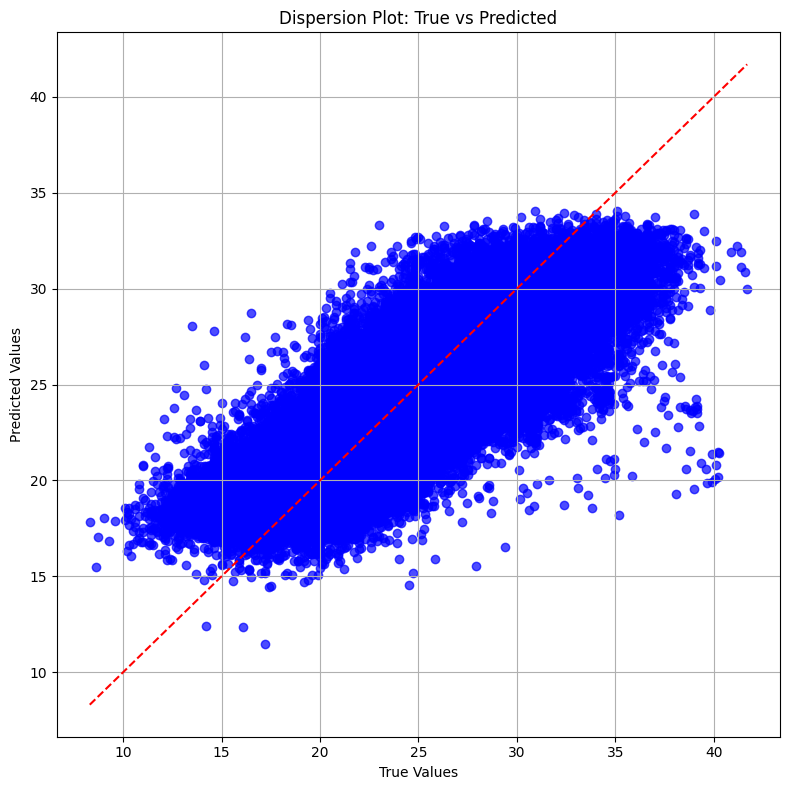

In [53]:
plot_dispersion(model, X_test, y_test)

In [15]:
# Limpar memória GPU antes de executar funções de plot
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory before plotting: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    print(f"GPU Memory cached: {torch.cuda.memory_reserved()/1e9:.2f} GB")
    print("✅ GPU cache cleared!")

GPU Memory before plotting: 0.02 GB
GPU Memory cached: 0.04 GB
✅ GPU cache cleared!


In [ ]:
def plot_real_vs_predicted(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device 
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu() 
            predictions.append(batch_pred)

            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    plt.figure(figsize=(12, 6))
    plt.plot(y_true_np, label='Real', linewidth=2)
    plt.plot(y_pred_np, label='Predicted', linewidth=2)
    plt.title('Real vs Predicted Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('./plots/lstm_temp_real_x_pred.png')
    plt.show()

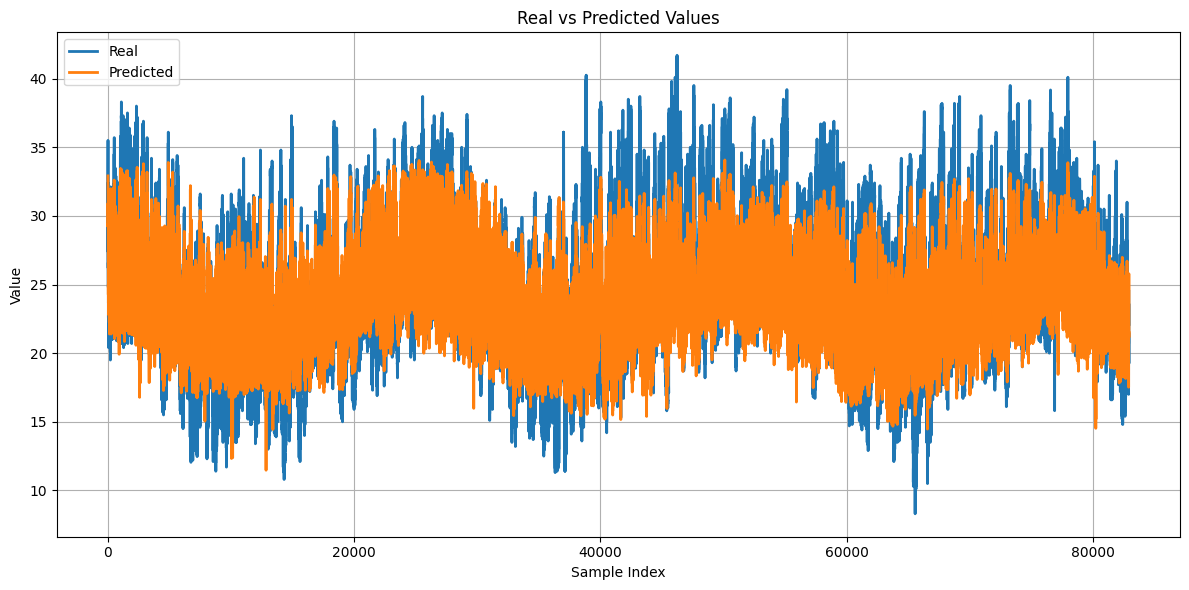

In [55]:
plot_real_vs_predicted(model, X_test, y_test)

In [ ]:
def print_rmse(model, X_test, y_test, batch_size=32):
    model.eval()
    device = next(model.parameters()).device

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()  
            predictions.append(batch_pred)
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()

    rmse = np.sqrt(mean_squared_error(y_true_np, y_pred_np))
    print(f"RMSE: {rmse:.4f}")

In [57]:
print_rmse(model, X_test, y_test)

RMSE: 2.6158


In [ ]:
def plot_lstm_prediction_over_time(model, X_test, y_test, timestamps, start_date=None, end_date=None, save=False, batch_size=32):
    model.eval()
    device = next(model.parameters()).device

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            batch_X = X_test[i:i+batch_size].to(device)
            batch_pred = model(batch_X).cpu()
            predictions.append(batch_pred)
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    
    y_pred = torch.cat(predictions, dim=0)
    y_true_np = y_test.cpu().numpy().flatten()
    y_pred_np = y_pred.numpy().flatten()
    timestamps = pd.to_datetime(timestamps)

    data = pd.DataFrame({
        'Timestamp': timestamps,
        'Actual': y_true_np,
        'Predicted': y_pred_np
    })

    if start_date:
        data = data[data['Timestamp'] >= pd.to_datetime(start_date)]
    if end_date:
        data = data[data['Timestamp'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(data['Timestamp'], data['Actual'], label='Actual Values', color='blue', linewidth=2)
    plt.plot(data['Timestamp'], data['Predicted'], label='Predicted Values', color='orange', linewidth=2)
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.title('LSTM: Actual vs. Predicted Values Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if save:
        plt.savefig(save)

    plt.show()

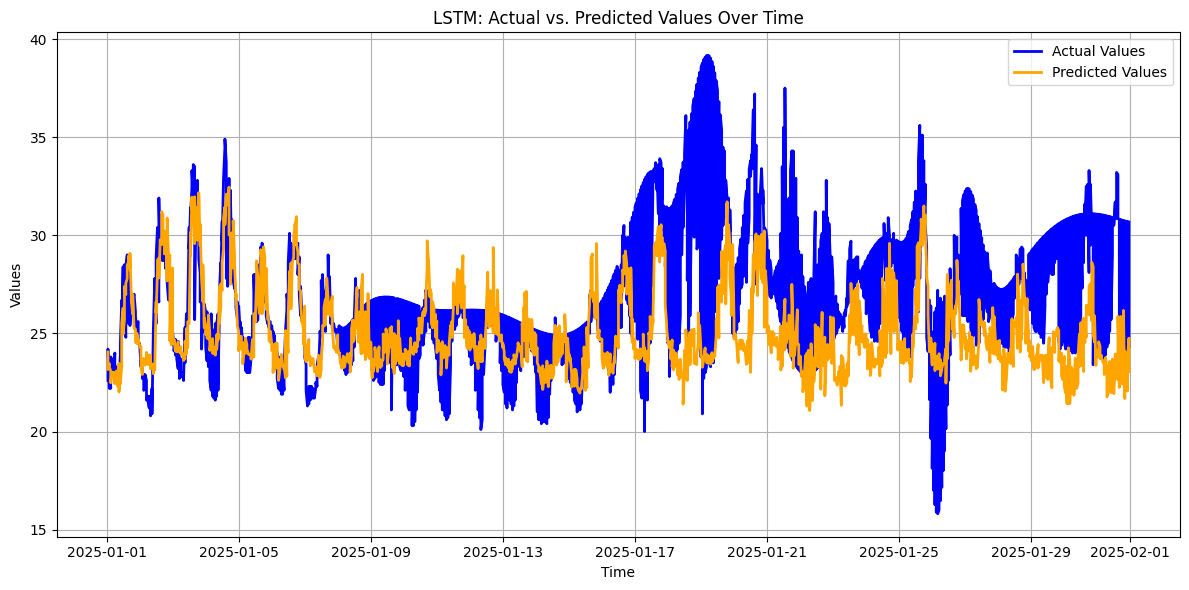

In [59]:
start_date = "2025-01-01 01:00:00"
end_date = "2025-01-31 23:00:00"

timestamps = pd.to_datetime(df['datetime'])
timestamps_for_plot = timestamps[T:T + N]
timestamps_test = timestamps_for_plot[train_size:]

plot_lstm_prediction_over_time(model, X_test, y_test, timestamps_test,start_date, end_date, save='./plots/lstm_temp_rvp.png')

In [ ]:
import shap
import gc
import numpy as np

num_background_samples = 100  
num_test_samples = 100 
max_batch_size = 5  
nsamples = 100  

torch.cuda.empty_cache()
gc.collect()

print("CONFIGURAÇÃO SHAP - TEMPERATURE LSTM:")
print(f"   Background samples: {num_background_samples}")
print(f"   Test samples: {num_test_samples}")
print(f"   Max batch size: {max_batch_size}")
print(f"   SHAP nsamples: {nsamples}")

background_data = X_train[:num_background_samples].cpu().numpy()
test_data = X_test[:num_test_samples].cpu().numpy()

background_flat = background_data.reshape(background_data.shape[0], -1)
test_flat = test_data.reshape(test_data.shape[0], -1)

print(f"   Background shape: {background_flat.shape}")
print(f"   Test shape: {test_flat.shape}")

def lstm_predict_wrapper_precipitation(X_flat):
    """
    Wrapper ultra-conservador para LSTM
    """
    if len(X_flat.shape) == 1:
        X_flat = X_flat.reshape(1, -1)
    
    batch_size = X_flat.shape[0]
    X_3d = X_flat.reshape(batch_size, T, D)
    
    predictions = []
    
    for i in range(0, batch_size, max_batch_size):
        torch.cuda.empty_cache()
        
        end_idx = min(i + max_batch_size, batch_size)
        batch_3d = X_3d[i:end_idx]
        
        X_tensor = torch.from_numpy(batch_3d.astype(np.float32)).to(device)
        
        model.eval()
        with torch.no_grad():
            batch_pred = model(X_tensor).cpu().numpy()
            predictions.append(batch_pred)
        
        del X_tensor
    
    all_predictions = np.concatenate(predictions, axis=0)
    torch.cuda.empty_cache()
    
    return all_predictions.flatten()

print("Creating SHAP KernelExplainer...")
explainer = shap.KernelExplainer(lstm_predict_wrapper_precipitation, background_flat)

print("Computing SHAP values...")
shap_values = explainer.shap_values(test_flat, nsamples=nsamples)

print(f"SHAP values shape: {shap_values.shape}")

expected_samples = num_test_samples
actual_samples = shap_values.shape[0]
print(f"Amostras esperadas: {expected_samples}")
print(f"Amostras analisadas: {actual_samples}")

nan_count = np.isnan(shap_values).sum()
inf_count = np.isinf(shap_values).sum()
print(f"Valores NaN: {nan_count}")
print(f"Valores Inf: {inf_count}")

for i in range(min(3, actual_samples)):
    sample_sum = np.sum(shap_values[i])
    sample_abs_sum = np.sum(np.abs(shap_values[i]))
    print(f"Amostra {i}: Soma SHAP = {sample_sum:.6f}, Soma absoluta = {sample_abs_sum:.6f}")

torch.cuda.empty_cache()
gc.collect()

CONFIGURAÇÃO SHAP - TEMPERATURE LSTM:
   Background samples: 100
   Test samples: 100
   Max batch size: 5
   SHAP nsamples: 100
   Background shape: (100, 340)
   Test shape: (100, 340)
Creating SHAP KernelExplainer...
Computing SHAP values...


 16%|█▌        | 16/100 [00:58<04:59,  3.57s/it]c:\Users\janse\Playground\final_project_AM\extreme-waether-forecasting\.venv\Lib\site-packages\shap\explainers\_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
 22%|██▏       | 22/100 [01:20<04:39,  3.58s/it]c:\Users\janse\Playground\final_project_AM\extreme-waether-forecasting\.venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=9.584e-02, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-08. Reduce max_iter or inc

SHAP values shape: (100, 340)
Amostras esperadas: 100
Amostras analisadas: 100
Valores NaN: 0
Valores Inf: 0
Amostra 0: Soma SHAP = 8.823442, Soma absoluta = 9.354009
Amostra 1: Soma SHAP = 6.630092, Soma absoluta = 9.563347
Amostra 2: Soma SHAP = 8.893747, Soma absoluta = 9.531290


0

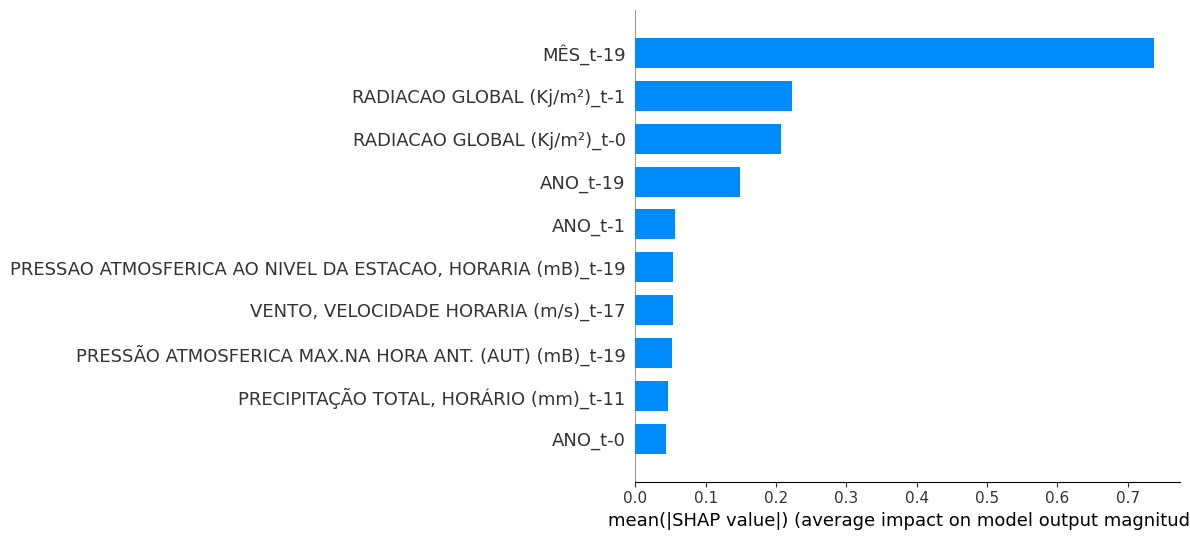

In [ ]:
base_features = [
    'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
    'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)', 
    'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
    'RADIACAO GLOBAL (Kj/m²)',
    'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
    'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'VENTO, DIREÇÃO HORARIA (gr) (° (gr))',
    'VENTO, RAJADA MAXIMA (m/s)',
    'VENTO, VELOCIDADE HORARIA (m/s)',
    'ANO', 'MÊS', 'DIA', 'HORA', 'MINUTO', 'SEGUNDO'
]

feature_names_lstm = []
for t in range(T-1, -1, -1): 
    for feature in base_features:
        if t == 0:
            feature_names_lstm.append(f"{feature}_t-{t}")
        else:
            feature_names_lstm.append(f"{feature}_t-{t}")

plt.figure(figsize=(12, 8))

shap.summary_plot(
    shap_values, 
    features=test_flat, 
    feature_names=feature_names_lstm, 
    plot_type="bar", 
    max_display=10,
    show=False
)
plt.tight_layout()
plt.subplots_adjust(left=0.3) 
plt.savefig('./plots/lstm_temp_shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()